In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
import os
import collections

import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import tifffile

import pppc
from pppc.configs import InferenceConfigDict
from pppc.core import PtychoNNProbePositionCorrector, ProbePositionCorrectorChain
from pppc.ptychonn.model import PtychoNNModel
from pppc.io import DataFileHandle, NPZFileHandle, VirtualDataFileHandle
from pppc.position_list import ProbePositionList
from pppc.reconstructor import VirtualReconstructor
from pppc.util import class_timeit

[2024-03-18 09:39:50,672] Note: NumExpr detected 32 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.
[2024-03-18 09:39:50,674] NumExpr defaulting to 8 threads.


In [3]:
matplotlib.rc('font',family='Times New Roman')
matplotlib.rcParams['font.size'] = 14
plt.viridis()

<Figure size 640x480 with 0 Axes>

In [4]:
scan_idx = 235
save_figs = False
output_dir = os.path.join('outputs', 'test{}'.format(scan_idx))
if not os.path.isdir(output_dir):
    os.makedirs(output_dir)

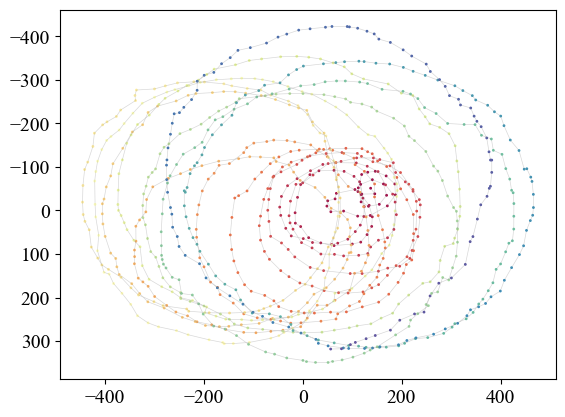

In [5]:
#psize_nm = np.load('data/scan221_raw.npz')['pixelsize'] * 1e9
psize_nm = 8
probe_pos_list = ProbePositionList(file_path='data/pos{}.csv'.format(scan_idx),
                                   unit='m', psize_nm=psize_nm, convert_to_pixel=True, first_is_x=False)
fig, ax, scat = probe_pos_list.plot(show=False, return_obj=True)
if save_figs:
    fig.savefig('outputs/test{}/path_plot_true.pdf'.format(scan_idx))
else:
    plt.show()

In [6]:
scaling_dict = collections.defaultdict(lambda: 1.0, {236: 0.5, 239: 0.5, 240: 0.25, 241: 0.25, 242: 0.25, 250: 0.5, 251: 0.5, 252: 0.25, 253: 0.25})
s = scaling_dict[scan_idx]
probe_pos_list_baseline = np.genfromtxt('data/pos221.csv', delimiter=',').astype('float32') / (psize_nm * 1e-9) * s  # Baseline

In [7]:
try:
    recons = tifffile.imread('outputs/pred_test{}_model_phaseOnly_BN_36SpiralDatasets_meanSubStdData_cleaned_valRatio_10/pred_phase.tiff'.format(scan_idx))
except:
    print('Reading images from scan### folder.')
    recons = tifffile.imread('outputs/pred_scan{}_model_36SpiralDatasets_compWithTransConv_model_PtychoNNTransposedConvModel_nLevels_5_lossFunction_MSELoss_batchSizePerProcess_32_learningRatePerProcess_0.0001/pred_phase.tiff'.format(scan_idx))

reconstructor = VirtualReconstructor(InferenceConfigDict())
reconstructor.set_object_image_array(recons)

config_dict = InferenceConfigDict(
    dp_data_file_handle=VirtualDataFileHandle('', dp_shape=recons.shape[1:], num_dps=recons.shape[0]),
    ptycho_reconstructor=reconstructor,
    random_seed=196,
    debug=False,
    probe_position_list=None,
    baseline_position_list=ProbePositionList(position_list=probe_pos_list_baseline)
)

recons.shape

(961, 128, 128)

Serial correction

In [8]:
config_dict.load_from_json(os.path.join('config_jsons', 'config_{}.json'.format(scan_idx)))
config_dict

InferenceConfigDict(batch_size=1, model_path=None, model=None, ptycho_reconstructor=<pppc.reconstructor.VirtualReconstructor object at 0x7f30438fa7d0>, dp_data_path=None, prediction_output_path=None, cpu_only=False, onnx_mdl=None, registration_params=RegistrationConfigDict(registration_method='error_map', max_shift=40, do_subpixel=True, subpixel_fitting_window_size=5, subpixel_diff_tolerance=2.0, subpixel_fitting_check_coefficients=True, sift_outlier_removal_method='trial_error', sift_border_exclusion_length=16, registration_downsample=1, hybrid_registration_algs=('error_map_multilevel', 'error_map_expandable', 'sift'), hybrid_registration_tols=(0.15, 0.3, 0.3), nonhybrid_registration_tol=None, registration_tol_schedule=None, min_roi_stddev=0.2, use_baseline_offsets_for_points_on_same_row=False, use_baseline_offsets_for_unregistered_points=False, use_baseline_offsets_for_uncertain_pairs=False, use_fast_errormap=False, errormap_error_check_tol=0.3), reconstruction_image_path=None, dp_da

In [9]:
corrector_chain = ProbePositionCorrectorChain(config_dict)
corrector_chain.build()

[2024-03-18 09:39:53,018] Now running iteration 0.
[2024-03-18 09:39:53,020] Random seed is set to 196.


batch_size: 1
model_path: None
model: None
ptycho_reconstructor: <pppc.reconstructor.VirtualReconstructor object at 0x7f30438fa7d0>
dp_data_path: None
prediction_output_path: None
cpu_only: False
onnx_mdl: None
registration_params: registration_method: hybrid
max_shift: 40
do_subpixel: True
subpixel_fitting_window_size: 5
subpixel_diff_tolerance: 2.0
subpixel_fitting_check_coefficients: True
sift_outlier_removal_method: trial_error
sift_border_exclusion_length: 16
registration_downsample: 1
hybrid_registration_algs: ['error_map_expandable', 'sift']
hybrid_registration_tols: [0.3, 0.15]
nonhybrid_registration_tol: None
registration_tol_schedule: None
min_roi_stddev: 0.2
use_baseline_offsets_for_points_on_same_row: False
use_baseline_offsets_for_unregistered_points: False
use_baseline_offsets_for_uncertain_pairs: False
use_fast_errormap: False
errormap_error_check_tol: 0.3
registration_method_multiiter: ['hybrid', 'hybrid', 'hybrid']
hybrid_registration_algs_multiiter: [['error_map_expan

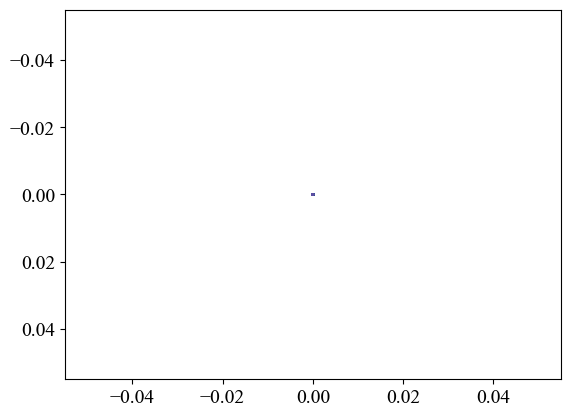

  2%|█▎                                                                       | 17/960 [00:04<04:23,  3.57it/s][2024-03-18 09:39:58,221] Rejected quadratic fitting because it is too far away from integer solution.
[2024-03-18 09:39:58,223] Result failed quality check, so I am increasing max shift to 40. (offset = [ 24. -30.], a = 0.0013078298307098724, b = -0.00010631139051222108, min_error = 0.21276680453806218)
[2024-03-18 09:39:58,685] Rejected quadratic fitting because it is too far away from integer solution.
  3%|█▉                                                                       | 25/960 [00:07<04:40,  3.33it/s][2024-03-18 09:40:01,027] Rejected quadratic fitting because it is too far away from integer solution.
[2024-03-18 09:40:01,029] Result failed quality check, so I am increasing max shift to 40. (offset = [-9. 30.], a = 0.002798444450221215, b = 0.000929410460635792, min_error = 0.1664381481859669)
  4%|██▌                                                              

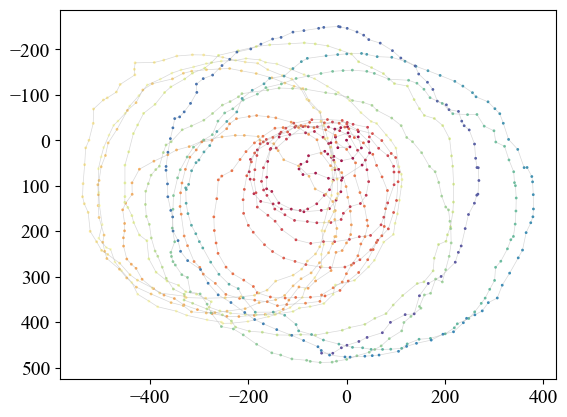

In [10]:
corrector_chain.run_correction_iteration(0)

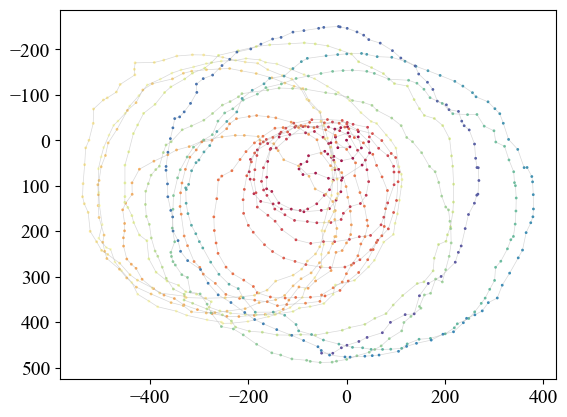

In [11]:
corrector_s = corrector_chain.corrector_list[-1]
fig, ax, scat = corrector_s.new_probe_positions.plot(return_obj=True, show=False)
if save_figs:
    fig.savefig('outputs/test{}/path_plot_serial.pdf'.format(scan_idx))
else:
    plt.show()

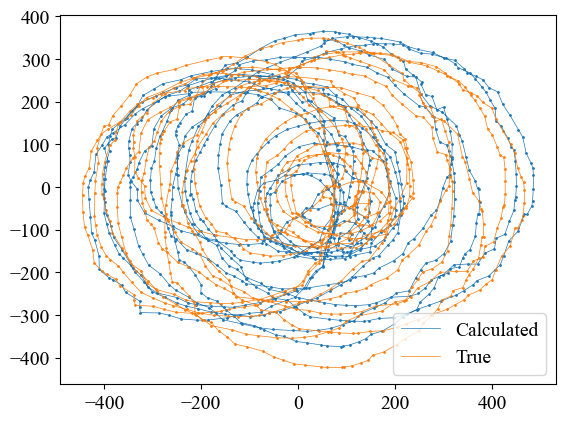

In [12]:
probe_pos_list_calc = corrector_s.new_probe_positions.array
probe_pos_list_true = np.genfromtxt('data/pos{}.csv'.format(scan_idx), delimiter=',').astype('float32') / (8 * 1e-9)
probe_pos_list_calc = probe_pos_list_calc - np.mean(probe_pos_list_calc, axis=0)
probe_pos_list_true = probe_pos_list_true - np.mean(probe_pos_list_true, axis=0)
#probe_pos_list_calc = probe_pos_list_calc * 1.02
plt.scatter(probe_pos_list_calc[:, 1], probe_pos_list_calc[:, 0], s=1)
plt.scatter(probe_pos_list_true[:, 1], probe_pos_list_true[:, 0], s=1)
plt.plot(probe_pos_list_calc[:, 1], probe_pos_list_calc[:, 0], linewidth=0.5, label='Calculated')
plt.plot(probe_pos_list_true[:, 1], probe_pos_list_true[:, 0], linewidth=0.5, label='True')
plt.legend()

[2024-03-18 09:45:14,569] Now running iteration 1.
[2024-03-18 09:45:14,570] Using result from the last iteration to initialize probe position array...
[2024-03-18 09:45:14,571] Random seed is set to 196.


batch_size: 1
model_path: None
model: None
ptycho_reconstructor: <pppc.reconstructor.VirtualReconstructor object at 0x7f30438fa7d0>
dp_data_path: None
prediction_output_path: None
cpu_only: False
onnx_mdl: None
registration_params: registration_method: hybrid
max_shift: 40
do_subpixel: True
subpixel_fitting_window_size: 5
subpixel_diff_tolerance: 2.0
subpixel_fitting_check_coefficients: True
sift_outlier_removal_method: trial_error
sift_border_exclusion_length: 16
registration_downsample: 1
hybrid_registration_algs: ['error_map_expandable', 'sift']
hybrid_registration_tols: [0.15, 0.1]
nonhybrid_registration_tol: None
registration_tol_schedule: None
min_roi_stddev: 0.2
use_baseline_offsets_for_points_on_same_row: False
use_baseline_offsets_for_unregistered_points: False
use_baseline_offsets_for_uncertain_pairs: False
use_fast_errormap: False
errormap_error_check_tol: 0.3
registration_method_multiiter: ['hybrid', 'hybrid', 'hybrid']
hybrid_registration_algs_multiiter: [['error_map_expan

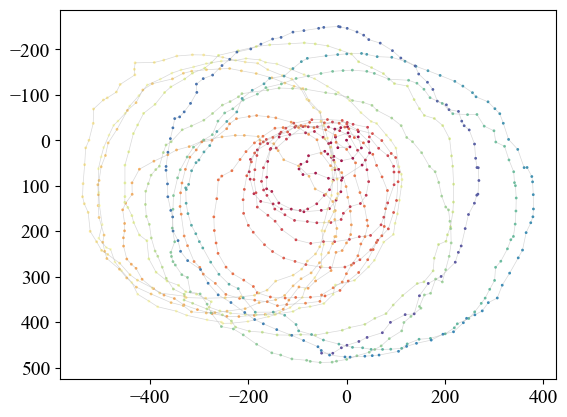

  0%|                                                                                  | 0/961 [00:00<?, ?it/s][2024-03-18 09:45:15,268] Rejected quadratic fitting because it is too far away from integer solution.
[2024-03-18 09:45:15,271] Large error after applying offset (0.33077669771330376).
[2024-03-18 09:45:15,272] Switching to sift...
[2024-03-18 09:45:15,316] Large error after applying offset (0.21545460135301592).
[2024-03-18 09:45:15,824] Result failed quality check, so I am increasing max shift to 40. (offset = [-11.2917336    6.93825003], a = 0.004226022593072351, b = 0.0024196684711521553, min_error = 0.6522448302988145)
[2024-03-18 09:45:16,246] Large error after applying offset (0.6205282184754485).
[2024-03-18 09:45:16,247] Switching to sift...
[2024-03-18 09:45:16,296] Large error after applying offset (0.4006791259080069).
  0%|                                                                          | 1/961 [00:01<24:39,  1.54s/it][2024-03-18 09:45:16,805] Rejected q

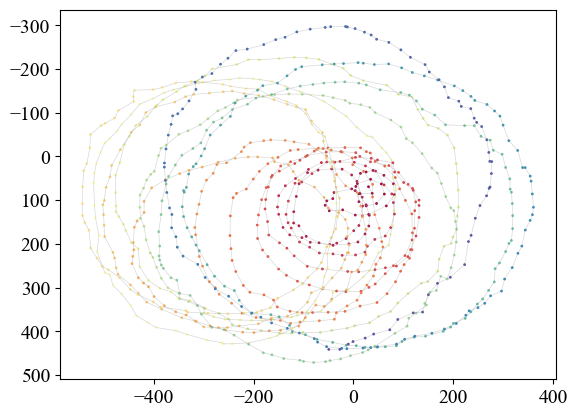

In [13]:
corrector_chain.run_correction_iteration(1)

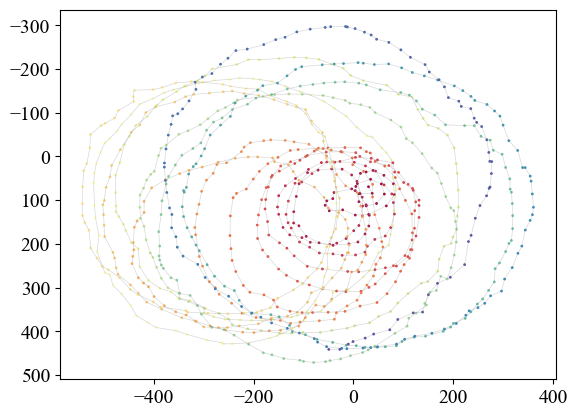

In [14]:
corrector_c1 = corrector_chain.corrector_list[1]
fig, ax, scat = corrector_c1.new_probe_positions.plot(return_obj=True, show=False)
if save_figs:
    fig.savefig('outputs/test{}/path_plot_collective_iter_1_nn_12_sw_1e-2.pdf'.format(scan_idx), format='pdf')
else:
    plt.show()

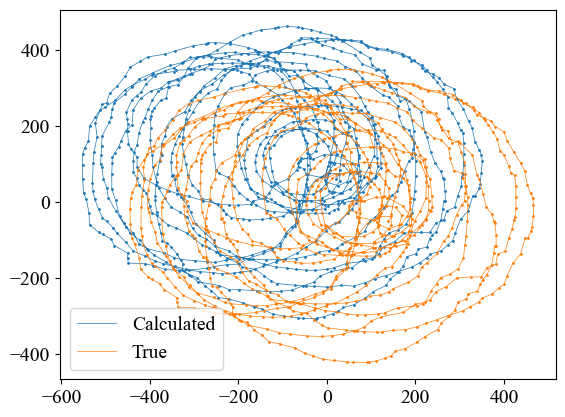

In [15]:
probe_pos_list_calc = corrector_c1.new_probe_positions.array
probe_pos_list_true = np.genfromtxt('data/pos{}.csv'.format(scan_idx), delimiter=',').astype('float32') / (8 * 1e-9)
# probe_pos_list_calc = probe_pos_list_calc - probe_pos_list_calc[0]
# probe_pos_list_true = probe_pos_list_true - probe_pos_list_true[0]
probe_pos_list_calc = probe_pos_list_calc - probe_pos_list_calc.mean()
probe_pos_list_true = probe_pos_list_true - probe_pos_list_true.mean()
# probe_pos_list_calc = probe_pos_list_calc * 1.02
plt.scatter(probe_pos_list_calc[:, 1], probe_pos_list_calc[:, 0], s=1)
plt.scatter(probe_pos_list_true[:, 1], probe_pos_list_true[:, 0], s=1)
plt.plot(probe_pos_list_calc[:, 1], probe_pos_list_calc[:, 0], linewidth=0.5, label='Calculated')
plt.plot(probe_pos_list_true[:, 1], probe_pos_list_true[:, 0], linewidth=0.5, label='True')
plt.legend()
# plt.ylim([-200, 200])
# plt.xlim([-200, 200])

[2024-03-18 10:00:18,104] Now running iteration 2.
[2024-03-18 10:00:18,106] Using result from the last iteration to initialize probe position array...
[2024-03-18 10:00:18,107] Random seed is set to 196.


batch_size: 1
model_path: None
model: None
ptycho_reconstructor: <pppc.reconstructor.VirtualReconstructor object at 0x7f30438fa7d0>
dp_data_path: None
prediction_output_path: None
cpu_only: False
onnx_mdl: None
registration_params: registration_method: hybrid
max_shift: 40
do_subpixel: True
subpixel_fitting_window_size: 5
subpixel_diff_tolerance: 2.0
subpixel_fitting_check_coefficients: True
sift_outlier_removal_method: trial_error
sift_border_exclusion_length: 16
registration_downsample: 1
hybrid_registration_algs: ['error_map_expandable', 'sift']
hybrid_registration_tols: [0.15, 0.1]
nonhybrid_registration_tol: None
registration_tol_schedule: None
min_roi_stddev: 0.2
use_baseline_offsets_for_points_on_same_row: False
use_baseline_offsets_for_unregistered_points: False
use_baseline_offsets_for_uncertain_pairs: False
use_fast_errormap: False
errormap_error_check_tol: 0.3
registration_method_multiiter: ['hybrid', 'hybrid', 'hybrid']
hybrid_registration_algs_multiiter: [['error_map_expan

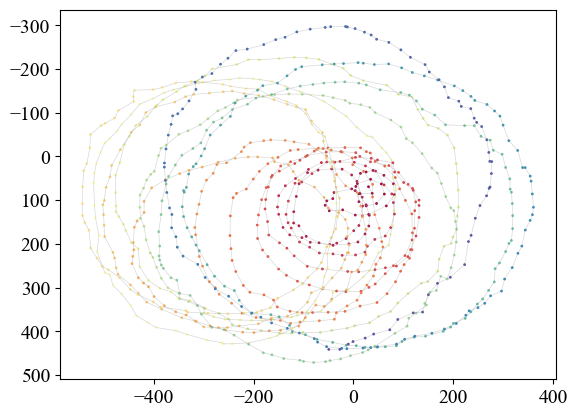

  1%|▋                                                                         | 9/961 [00:08<14:29,  1.10it/s][2024-03-18 10:00:27,056] Rejected quadratic fitting because it is too far away from integer solution.
[2024-03-18 10:00:27,059] Result failed quality check, so I am increasing max shift to 40. (offset = [30.  1.], a = 0.001651674677795886, b = 0.0003102319177522069, min_error = 0.17410003217812753)
[2024-03-18 10:00:27,566] Large error after applying offset (0.5007078467909264).
[2024-03-18 10:00:27,569] Switching to sift...
[2024-03-18 10:00:27,628] Large error after applying offset (0.10320522933338443).
[2024-03-18 10:00:27,935] Result failed quality check, so I am increasing max shift to 40. (offset = [-10.71328566  -5.3637536 ], a = 0.0047140947039284505, b = 0.0009466104750648961, min_error = 0.015092232034760945)
[2024-03-18 10:00:28,432] Rejected quadratic fitting because it is too far away from integer solution.
  2%|█▎                                                

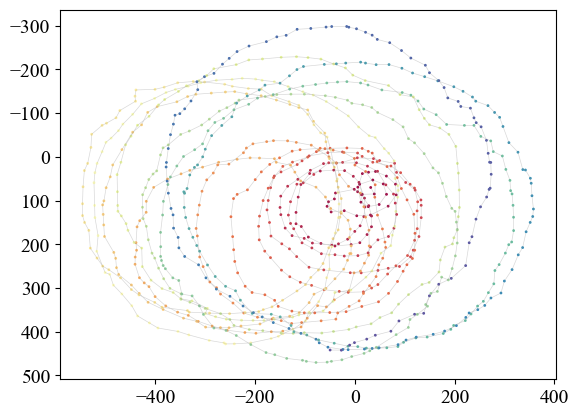

In [16]:
# corrector_chain.corrector_list.append(corrector_c1)
corrector_chain.run_correction_iteration(2)

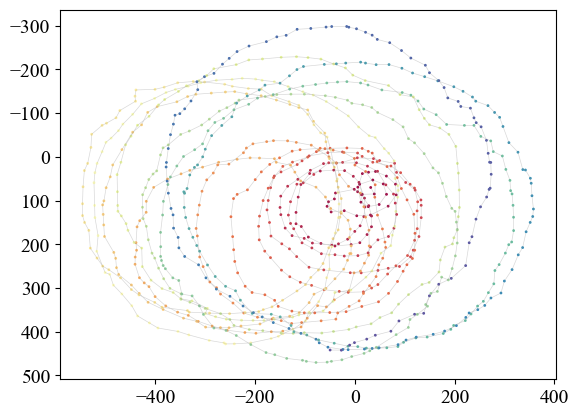

In [17]:
corrector_c2 = corrector_chain.corrector_list[2]
#corrector_c2 = corrector
fig, ax, scat = corrector_c2.new_probe_positions.plot(return_obj=True, show=False)
if save_figs:
    fig.savefig('outputs/test{}/path_plot_collective_iter_2_nn_12_sw_1e-3_1e-2.pdf'.format(scan_idx), format='pdf')
else:
    plt.show()

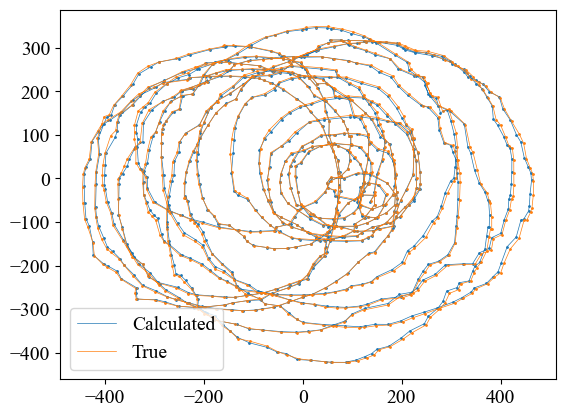

In [18]:
probe_pos_list_calc = corrector_c2.new_probe_positions.array
probe_pos_list_true = np.genfromtxt('data/pos{}.csv'.format(scan_idx), delimiter=',').astype('float32') / (8 * 1e-9)
probe_pos_list_calc = probe_pos_list_calc - np.mean(probe_pos_list_calc, axis=0)
probe_pos_list_true = probe_pos_list_true - np.mean(probe_pos_list_true, axis=0)
# probe_pos_list_calc = probe_pos_list_calc * 1.04
plt.scatter(probe_pos_list_calc[:, 1], probe_pos_list_calc[:, 0], s=1)
plt.scatter(probe_pos_list_true[:, 1], probe_pos_list_true[:, 0], s=1)
plt.plot(probe_pos_list_calc[:, 1], probe_pos_list_calc[:, 0], linewidth=0.5, label='Calculated')
plt.plot(probe_pos_list_true[:, 1], probe_pos_list_true[:, 0], linewidth=0.5, label='True')
plt.legend()
if save_figs:
    plt.savefig('outputs/test{}/comparison_path_plot_collective_iter_2_nn_12_sw_1e-3_1e-2.pdf'.format(scan_idx))
else:
    plt.show()

In [19]:
if save_figs:
    corrector_c2.new_probe_positions.to_csv(os.path.join(output_dir, 'calc_pos_{}_collective_niters_2_beta_0p5_nn_12_sw_1e-2_1e-3.csv'.format(scan_idx)), psize_nm=psize_nm)